# Helping Hotels in times of flexible bookings

As the pandemic has changed the tourism industry customers are more and more used to flexibility options and cancellations when it comes to hotel bookings. Hotels are therefore offering their customers more options when it comes to changing and cancelling an existing booking. However, this imposes cost to a hotel business, as rooms are reserved for a long time and then might be cancelled shortly in advance. This short time is often not enough to find a new, paying customer for the hotel room. 

Therefore hotels might use a concept that is already prevailent in airlines: Overbooking the rooms they actually have. By accepting more bookings than a hotel has rooms, it can make sure to be closer to full capacity utilization. However, this imposes the risk of not having rooms available and having to reject customers that have a reserved room. This would be a very bad situation. Therefore it can be very beneficial to build a Machine Learning model that successfully predicts whether a customer is likely to cancel their booking. That is the goal of this work. 

### Select a performance measure


### Check the assumptions

## 0. Imports & Data Access

In [205]:
import matplotlib.pyplot as plt
import missingno
import pandas as pd
import seaborn as sns
import os
from datetime import timedelta

plt.style.use('seaborn')

In [206]:
exec_directory = os.getcwd()
main_directory = "Hotel-Booking-ML"
main_dir_path = exec_directory[:exec_directory.find(main_directory) + len(main_directory)]
raw_data_files_location = f"{main_dir_path}/data/raw"
df = pd.read_csv(f"{raw_data_files_location}/hotel_booking.csv")

As a first step we'll drop the columns 'reservation_status' and 'reservation_status_date' as they include information on our label. The value 'canceled' in 'reservation_status' indicates the same as 'is_canceled', this obviously information we don't need and shouldn't feed into the model.

In [207]:
df.drop(columns = ['reservation_status', 'reservation_status_date' ], inplace = True)

## 1. Data Exploration

In [208]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


<AxesSubplot:>

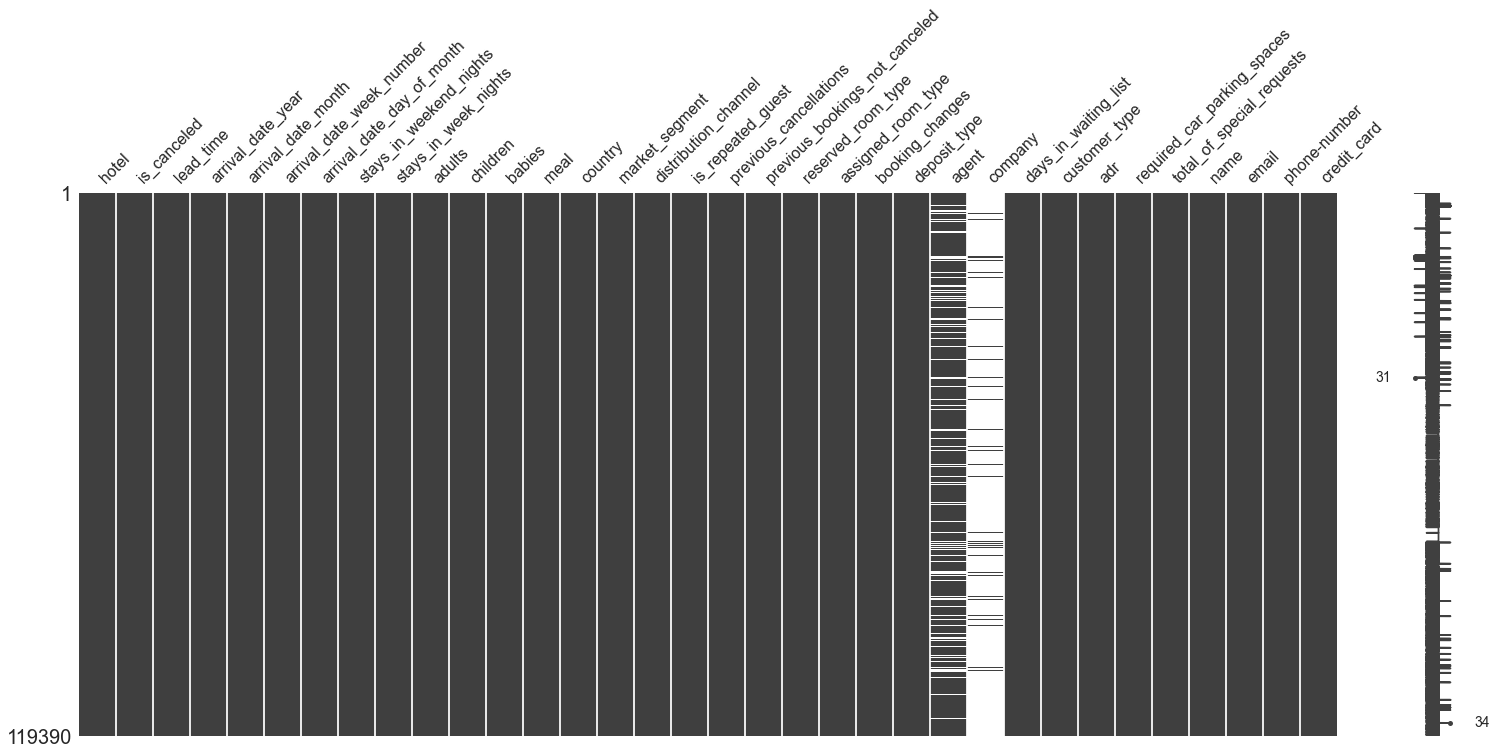

In [209]:
missingno.matrix(df)

#### Missing values

Luckily our dataset is complete for all features apart from agent and company. According to the data dictionary of the dataset these columns represent IDs of the agents and companies (in case of business travel) that made the bookings. Therefore it is likely that missing values do represent an information: a NA in 'company' indicates that the booking was not a business travel and a NA in 'agent' indicates that no agent was used for the booking, meaning that it was a direct booking.

Therefore we'll use OneHot encoding later on, to understand if there is a correlation between company, agent and our labels. 

#### Data transformation and aggregation. 

Before starting with the EDA we'll transform arrival and booking date to datetime format, transform the type of childern, calculate the number of total nights and retrieve the total number of guests.

In [210]:
df.dropna(subset=['children'], inplace=True)
df['children'] = df['children'].astype(int)

In [211]:
# Getting arrival and booking dates right
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
                         'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
df['arrival_date_month'] = df['arrival_date_month'].apply(lambda m: month_mapping[m])
df['arrival_date'] = pd.to_datetime(dict(year = df.arrival_date_year, 
                                         month = df.arrival_date_month, 
                                         day = df.arrival_date_day_of_month))
df['booking_date'] = df.apply(lambda r: r['arrival_date'] - timedelta(days=r['lead_time']), axis=1)
df['booking_date_day_of_week'] = df['booking_date'].dt.weekday

# Number of Guests
df['guests'] = df['adults'] + df['children'] + df['babies']

# Length of stay
df['stay_total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']


## 2. Exploratory Data Analysis

We firstly split the EDA for categorical and numerical features, as we'll perform different analysis methods. 

There are two exceptions here: 
- We'll see binary variables (with 0 and 1) as a numerical feature, as it can be analyzed with the methdos we use for the 'true' numerical features.
- The 'hotel' feature discribes whether the data is for a 'City Hotel' or a 'Resort Hotel', it will be analyzed in numerical features as well. This is because we want to identify if it is worth to split the data we have according to the hotel and build separate models for each of the hotels. 

In [215]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'name',
       'email', 'phone-number', 'credit_card', 'arrival_date', 'booking_date',
       'booking_date_day_of_week', 'guests', 'stay_total_nights'],
      dtype='object')

In [219]:
categorical_features = [ 'meal', 'country', 'market_segment', 'distribution_channel', 
                         'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'company', 
                         'customer_type']

df_num = df.drop(columns = categorical_features)

categorical_features.append('is_canceled')
df_cat = df[categorical_features]


### 2.1 Numerical features
#### 2.1.1 Correlations

First we'll take a lookt at collinearity in the data set, by pairplotting relevant features and calculating their correlations.

Please note that we are only using aggregated features here and not the features we calculated these aggregated ones on. For example, it wouldn't make sense to check for collinearity in guests with adults, children or babies as these variables are obviously correlated and won't be used side by side in the model. 

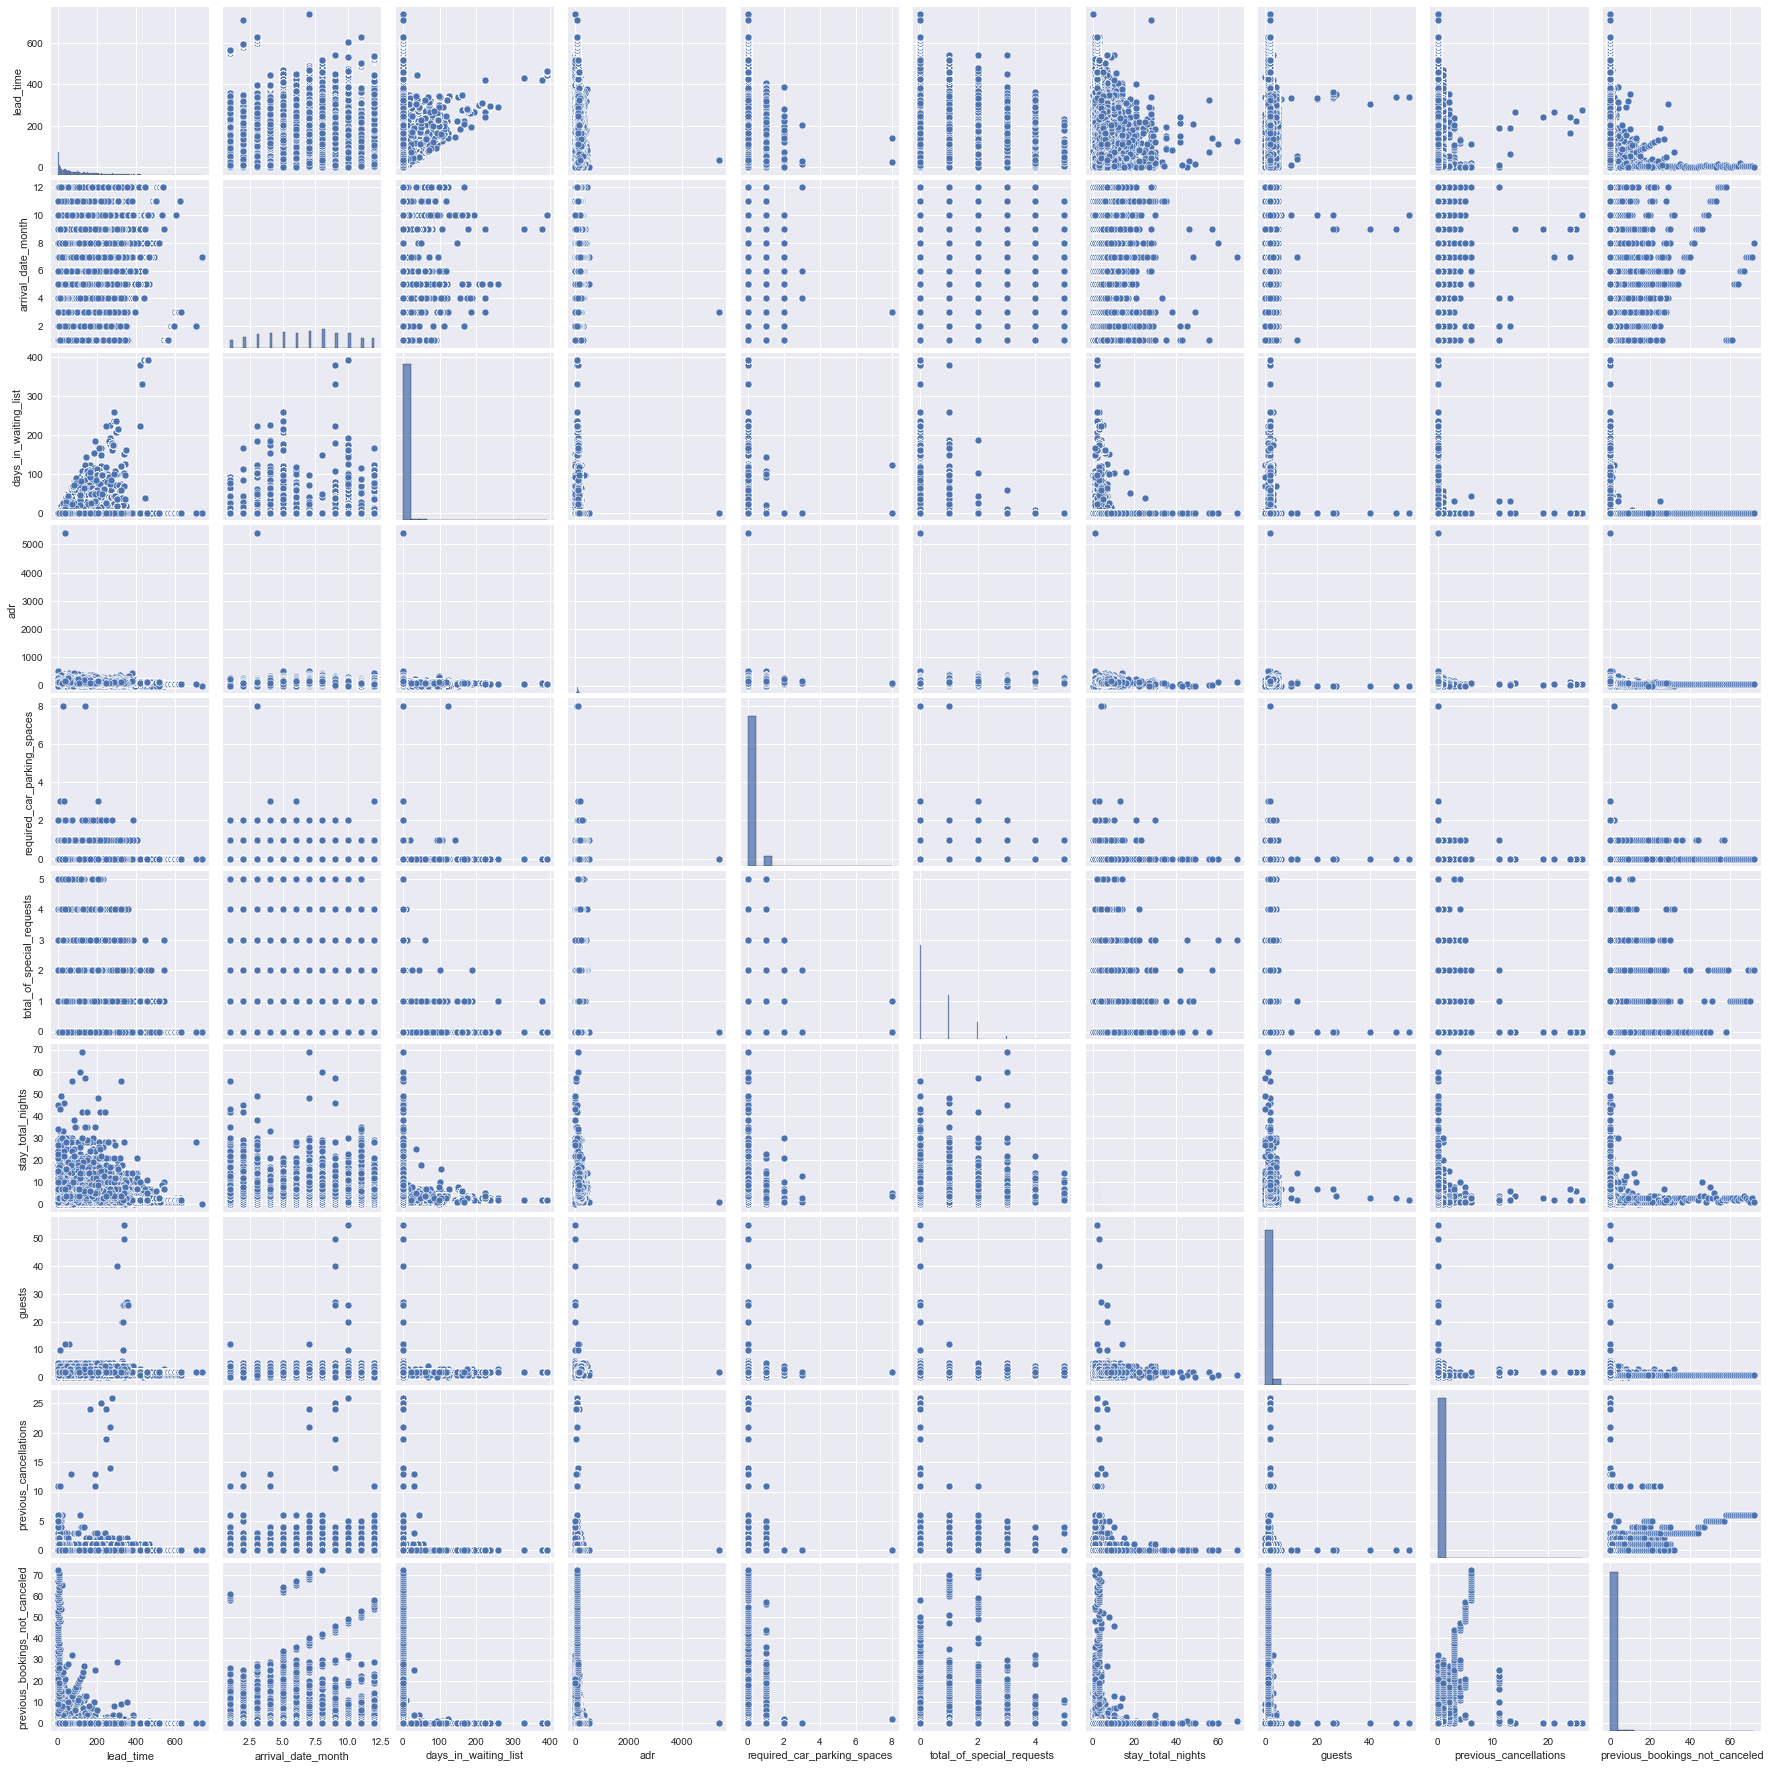

In [152]:
sns.pairplot(data=df_num[['lead_time', 'arrival_date_month','days_in_waiting_list', 'adr', 
                          'required_car_parking_spaces', 'total_of_special_requests',
                          'stay_total_nights', 'guests','previous_cancellations','previous_bookings_not_canceled']])
plt.show(sns)

In [162]:
df_corr = pd.DataFrame(df_num[['lead_time', 'arrival_date_month','days_in_waiting_list', 'adr', 
                          'required_car_parking_spaces', 'total_of_special_requests',
                          'stay_total_nights', 'guests','previous_cancellations','previous_bookings_not_canceled']].corr().unstack())
df_corr[df_corr[0] != 1].sort_values(by = 0)

0
lead_time                      required_car_parking_spaces    -0.116461
required_car_parking_spaces    lead_time                      -0.116461
guests                         previous_bookings_not_canceled -0.099096
previous_bookings_not_canceled guests                         -0.099096
lead_time                      total_of_special_requests      -0.095688
...                                                                 ...
                               days_in_waiting_list            0.170083
total_of_special_requests      adr                             0.172238
adr                            total_of_special_requests       0.172238
guests                         adr                             0.368144
adr                            guests                          0.368144

[90 rows x 1 columns]

The highest correlation among our features is the correlation of ADR (revenue per day) with the number of guests, this follows the logic that with the more people you stay in a hotel, the more you'll spend. When building the model we'll take a closer look if this becomes a problem. For the other features the correlations are really small and therefore no worry.  

Now, lets get the correlations of the **label** with the features, separately for the resort and city hotel to find out if they differ substiantially. This will be interesting when deciding whether to build separate models or not. 

In [133]:
correlations_all = df_num.corr()['is_canceled'].sort_values(ascending=False)
correlations_city = df_num[df_num['hotel'] == 'City Hotel'].corr()['is_canceled']
correlations_resort = df_num[df_num['hotel'] == 'Resort Hotel'].corr()['is_canceled']
correlations_df = correlations_all.to_frame().rename({'is_canceled': "All"}, axis=1)
correlations_df = correlations_df.join(correlations_city).rename({'is_canceled': "City"}, axis=1)
correlations_df = correlations_df.join(correlations_resort).rename({'is_canceled': "Resort"}, axis=1)
correlations_df

,All,City,Resort
is_canceled,1.000000,1.000000,1.000000
lead_time,0.293123,0.309242,0.229444
previous_cancellations,0.110133,0.166643,0.114173
adults,0.060017,0.053054,0.080546
days_in_waiting_list,0.054186,0.060965,-0.036301
adr,0.047557,-0.011965,0.109317
guests,0.046506,0.022580,0.103413
booking_date_day_of_week,0.034071,0.027870,0.029677
stays_in_week_nights,0.024765,0.048704,0.078477
stay_total_nights,0.017779,0.034588,0.083822


This already gives a good indication, but let's plot the data to make the difference easier to understand.

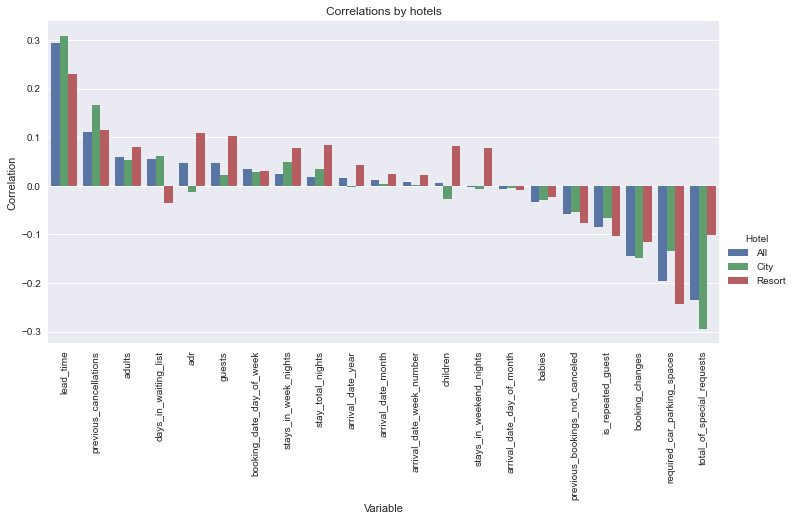

In [140]:
correlations_plot_df = pd.melt(correlations_df.drop('is_canceled'), ignore_index=False, var_name="Hotel", value_name="Correlation")
correlations_plot_df['Variable'] = correlations_plot_df.index
sns.catplot(data=correlations_plot_df, kind='bar', x='Variable', y='Correlation', hue='Hotel', aspect=2)
plt.xticks(rotation=90)
plt.title('Correlations by hotels')
plt.show()

This bar-chart shows that lead_time, previous_canellations, total_of_special_requests, required_car_parking_space and booking_changes have a correlation that is higher than 0.1 (in absolute terms). These are important candidates for our ML model later on. Additionally, the chart shows that for some features the correlation heavily depends on the kind of hotel we are looking at: For example, the number of total special requests is highly correlated with the cancellations at the city hotel, but not so much at the resort hotel. 

Based on this observation we will try out when building our first models, wether separate models or a joint model for both hotels performs better. 

#### 2.1.2 Frequency Distributions
# Add Descriptions here

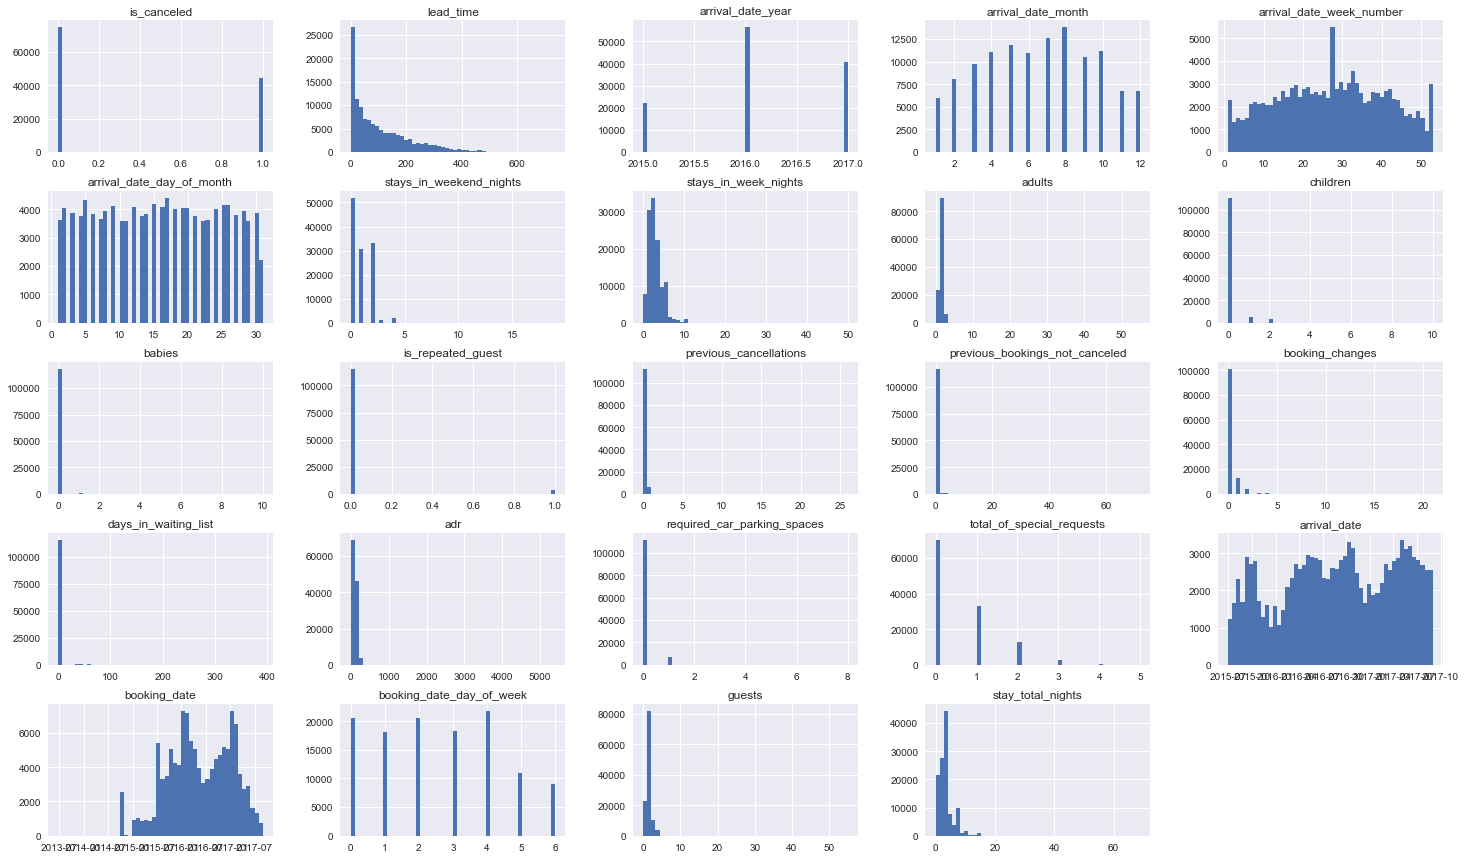

In [136]:
df_num.hist(bins=50, figsize=(25,15))
plt.show()

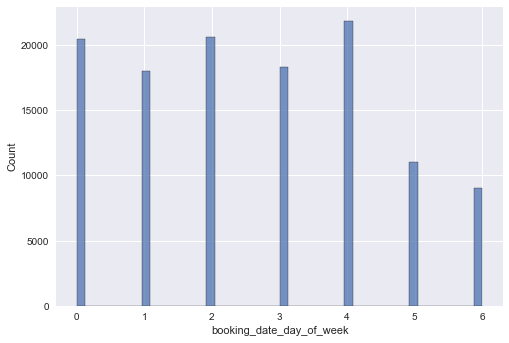

In [137]:
sns.histplot(df['booking_date_day_of_week'])
plt.show(sns)

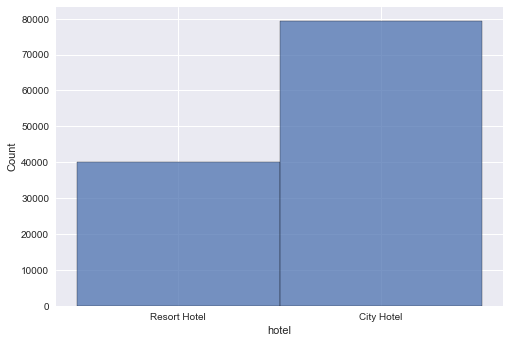

In [138]:
sns.histplot(df['hotel'])
plt.show(sns)

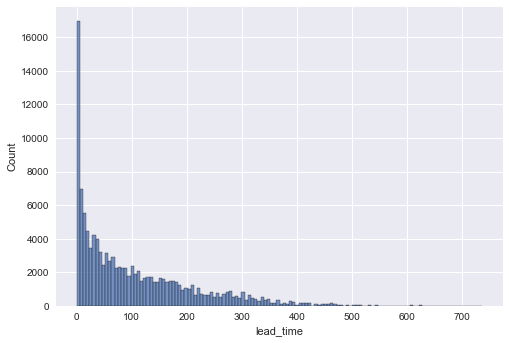

In [139]:
sns.histplot(df['lead_time'])
plt.show(sns)

### 2.2 Categorical variables

#### 2.2.1 Understanding the categories

Here we'll use df_cat, with all categorical features we have identified perviously. 

In [164]:
df_cat.columns

Index(['meal', 'country', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent',
       'company', 'customer_type'],
      dtype='object')

'Company' and 'agent' are columns with ids. Let's look at the values in the other ("true") categorical variables to get a feeling for what they are. 

In [222]:
df_cat_red[['meal']].value_counts(normalize = True)

meal     
BB           0.773173
HB           0.121145
SC           0.089206
Undefined    0.009792
FB           0.006684
dtype: float64

In [221]:
df_cat_red[['country']].value_counts(normalize = True).head(10)

country
PRT        0.408636
GBR        0.102012
FRA        0.087596
ESP        0.072062
DEU        0.061288
ITA        0.031674
IRL        0.028386
BEL        0.019698
BRA        0.018705
NLD        0.017696
dtype: float64

In [178]:
df_cat_red[['market_segment']].value_counts(normalize = True)

market_segment
Online TA         0.473054
Offline TA/TO     0.202863
Groups            0.165941
Direct            0.105582
Corporate         0.044352
Complementary     0.006224
Aviation          0.001985
dtype: float64

In [179]:
df_cat_red[['distribution_channel']].value_counts(normalize = True)

distribution_channel
TA/TO                   0.819778
Direct                  0.122669
Corporate               0.055928
GDS                     0.001617
Undefined               0.000008
dtype: float64

In [224]:
df_cat_red[['reserved_room_type']].value_counts(normalize = True)

reserved_room_type
A                     0.720302
D                     0.160831
E                     0.054738
F                     0.024266
G                     0.017540
B                     0.009331
C                     0.007807
H                     0.005034
P                     0.000101
L                     0.000050
dtype: float64

In [223]:
df_cat_red[['assigned_room_type']].value_counts(normalize = True)

assigned_room_type
A                     0.620282
D                     0.212102
E                     0.065385
F                     0.031419
G                     0.021384
C                     0.019893
B                     0.018084
H                     0.005964
I                     0.003041
K                     0.002337
P                     0.000101
L                     0.000008
dtype: float64

In [180]:
df_cat_red[['deposit_type']].value_counts(normalize = True)

deposit_type
No Deposit      0.876460
Non Refund      0.122184
Refundable      0.001357
dtype: float64

In [181]:
df_cat_red[['customer_type']].value_counts(normalize = True)

customer_type  
Transient          0.750616
Transient-Party    0.210410
Contract           0.034141
Group              0.004833
dtype: float64

Especially, the deposit type seems likely to have a high explanatory power. If you have made no deposit you are much more likely to cancel a booking than when you made a non-refundable deposit, right?

#### 2.2.2 Correlations of categorical variables with cancellations

Let's OneHot Encode the categories and IDs (for agent and company) in the next step and get their correlations with the cancellations. 

In [182]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(sparse = False)
df_cat_red_trans = pd.DataFrame(data = onehot.fit_transform(df_cat_red.drop(columns = 'is_canceled')),
                                columns = onehot.get_feature_names())

In [183]:
df_cat_red_trans = pd.concat([df_cat_red.is_canceled, df_cat_red_trans], axis = 1 )


Now we'll use this transformed dataframe of our categorical variables and find out how correlated they are with 'is_canceled'.

Watch out, the next cell takes quite a while to compute. 

In [184]:
df_cat_corr = df_cat_red_trans.corr()
df_cat_corr = df_cat_corr['is_canceled']

This is gives a dataframe of **xxxx** correlations with the label. Very likely, most of them will have a very low correlation with the label. Therefore, let's only look at the ones with a correlation of more than 0.05 (positive or negative).

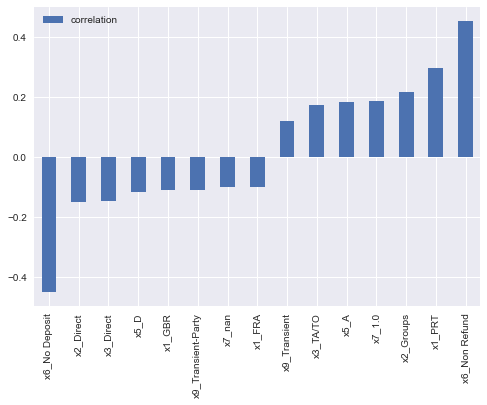

In [186]:
df_cat_corr_red = pd.DataFrame(df_cat_corr).rename({'is_canceled' : 'correlation'}, axis = 1)
df_cat_corr_red = df_cat_corr_red[(df_cat_corr_red['correlation'] >= 0.1 ) | (df_cat_corr_red['correlation'] <= -0.1) ]
df_cat_corr_red.sort_values(by = 'correlation')[:-1].plot(kind = 'bar')
plt.show()

This gives us a good indication, that especially x2 (= 'deposit_type') is likely to have a high explanatory power. But also x1 = ('Coutnry') equalling to Portugal, x2 (= 'market_segment') equalling to Groups, one value form the x5 (= 'agent') feature and x3 (= 'distribution_channel') can be important when building the model.